In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from itertools import islice
import os

### Data
BLAST search run times (preliminary stage plus traceback), in miliseconds, were collected when running 2546 blastp and 6490 blastn queries. The searches were run on two-node, 64-CPU clusters, one search at a time.

In [2]:
directory = 'data'
chunk_time = pd.read_csv(directory + '/' + 'nr-500-scrambled.tab', sep = '\t', index_col = 0)
num_requests = chunk_time.shape[1]
num_db_chunks = chunk_time.shape[0]
print('Number of requests: {}'.format(num_requests))
print('Number of dartabase chunks: {}'.format(num_db_chunks))
#chunk_time.head()

Number of requests: 2546
Number of dartabase chunks: 109


### Run time overview
For each BLAST search we computed 25-th, 50-th, and 75-th percentile of search time against a single database chunk. The following figure shows that single database chunk search times can be quite variable between queries.

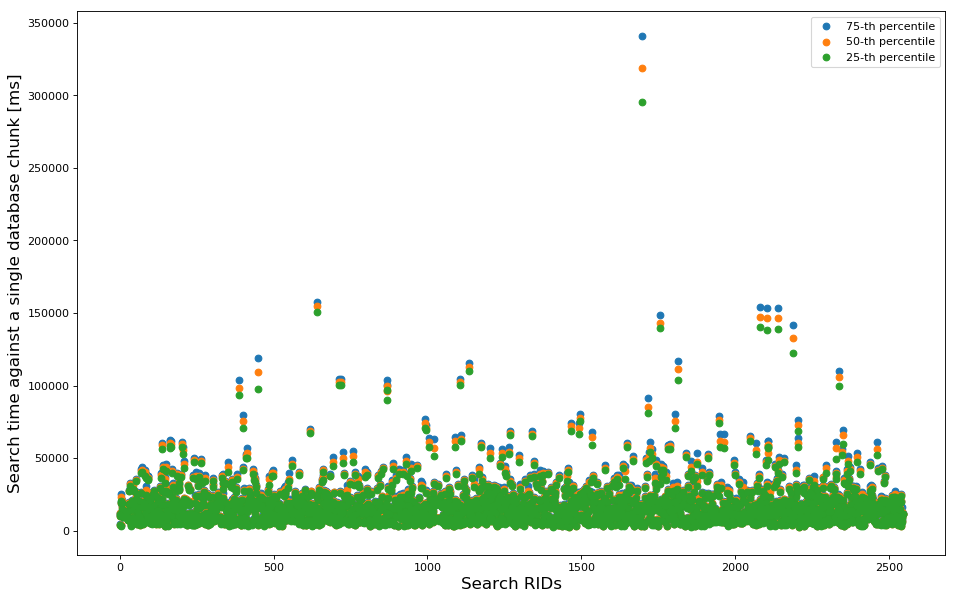

In [3]:
p25 = {}
p50 = {}
p75 = {}
for col in chunk_time:
    sorted_col = chunk_time[col].sort_values()
    p25[col] = sorted_col.iloc[int(num_db_chunks * 0.25)]
    p50[col] = sorted_col.iloc[int(num_db_chunks * 0.5)]
    p75[col] = sorted_col.iloc[int(num_db_chunks * 0.75)]

m = pd.DataFrame({'p25': p25, 'p50': p50, 'p75': p75})
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(range(0, num_requests), m['p75'])
plt.scatter(range(0, num_requests), m['p50'])
plt.scatter(range(0, num_requests), m['p25'])

plt.xlabel('Search RIDs', fontsize = 15)
plt.ylabel('Search time against a single database chunk [ms]', fontsize = 15)
fig = plt.legend(['75-th percentile', '50-th percentile', '25-th percentile'])

### Hot spots
We find hot spots as outlier data points that are larger than 1.5 times the interquarile distance from the 75-th percentile (the same way as shown in the box-and-wiskers plot). Then for each database chunk we count in how many searches it was a hot spot. Below we show top 20 most frequent hot spots.

In [4]:
outliers = None
for rid in chunk_time:
    t = chunk_time[rid]
    q = t.quantile(q = [0.25, 0.75], interpolation = 'nearest')
    # everything above this value is shown as an outlier in a box plot
    wisker = q[0.75] + 1.5 * (q[0.75] - q[0.25])
    
    if outliers is None:
        outliers = pd.DataFrame({rid: t - wisker})
    else:
        outliers[rid] = t - wisker
        
#find and count outliers/hotspots
hotspots = (outliers > 0).sum(axis = 1).sort_values(ascending = False)
perc = hotspots / num_requests

hh = pd.DataFrame({'Hot spot frequency': hotspots, 'Percentage of queries': perc})
hh.sort_values('Hot spot frequency', ascending = False).head(20)

,Hot spot frequency,Percentage of queries
nr_500M.53,265,0.104085
nr_500M.68,131,0.051453
nr_500M.19,127,0.049882
nr_500M.26,121,0.047526
nr_500M.16,111,0.043598
nr_500M.98,85,0.033386
nr_500M.18,72,0.028280
nr_500M.00,72,0.028280
nr_500M.61,72,0.028280
nr_500M.28,63,0.024745


### How bad is the hot spot
Here we show the number of queries for which the maximum database chunk search time is 1.5, 2, 3, 5, 10, or 20 times larger than the 75-th percentile.

In [5]:
m['max'] = chunk_time.max()
mm = m['max'] / m['p75']
count = {}
for i in [1.5, 2, 3, 5, 10, 20]:
    count[i] = (mm > i).sum()
pd.DataFrame({'Number of queries with max to 75-th percentile greater than': count})

,Number of queries with max to 75-th percentile greater than
1.5,128
2.0,44
3.0,11
5.0,0
10.0,0
20.0,0


#### Worst offenders
The figure below shows run times for top five database chunks that are hot spots for the largest number of queries. Hot spots are clearly visible.

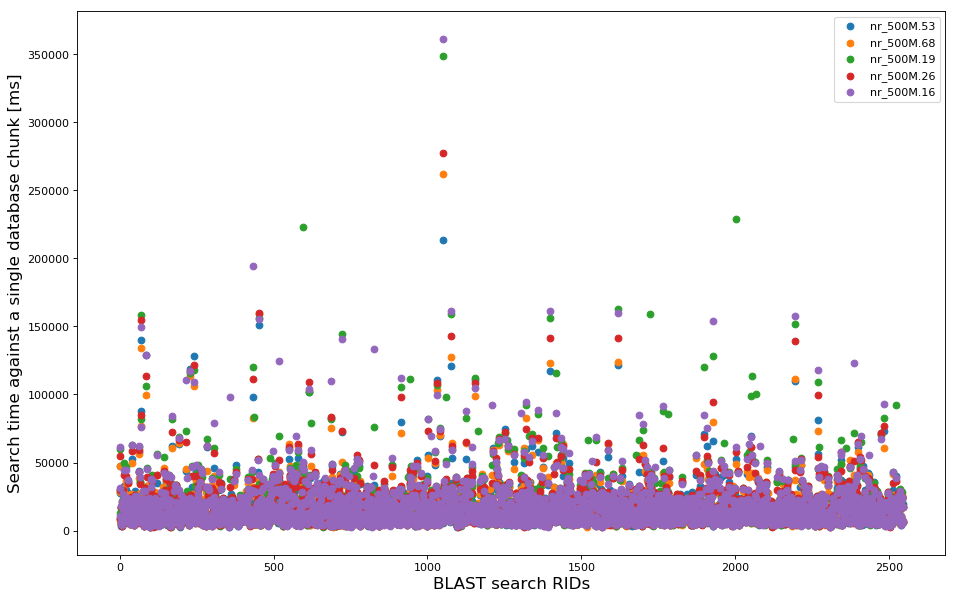

In [6]:
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
for index, value in islice(hotspots.iteritems(), 5):
    plt.scatter(range(0, chunk_time.shape[1]), chunk_time.loc[index])
plt.legend(hotspots.index[:5])
plt.xlabel('BLAST search RIDs', fontsize = 15)
fig = plt.ylabel('Search time against a single database chunk [ms]', fontsize = 15)

### Best behaving chunks
Below we show run times for the 5 best behaving chunks: these that are hotspots for the fewest number of RIDs. The largest data points are still close to all other points. We removed 78 RID's with search times much larger than most other RIDs (see the first figure).

Removed 78 variable RIDs


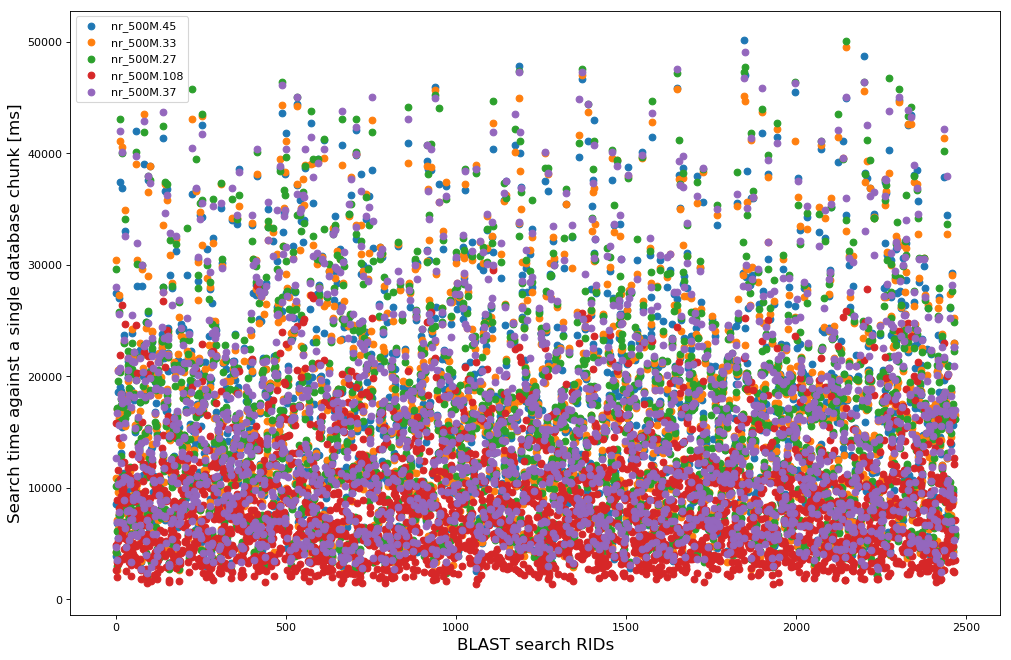

In [7]:
p75_limit = 50000

#print('{} of requests have 75-th percentile below {}'.format((m['p75'] < p75_limit).sum() / num_requests, p75_limit))
ch = pd.DataFrame()
for rid in chunk_time:
    if p75[rid] < p75_limit:
        ch[rid] = chunk_time[rid]

#chunk_time = ch
#num_requests = chunk_time.shape[1]
print('Removed {} variable RIDs'.format(chunk_time.shape[1] - ch.shape[1]))

plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for index, value in islice(hotspots.iteritems(), hotspots.shape[0] - 5, None):
    plt.scatter(range(0, ch.shape[1]), ch.loc[index])
plt.legend(hotspots.index[-5:])
plt.xlabel('BLAST search RIDs', fontsize = 15)
fig = plt.ylabel('Search time against a single database chunk [ms]', fontsize = 15)

### Worst behaving queries
Let us now look at search requests with the largest number of hotspots and hot spots taking the longest to search (the next two figures).

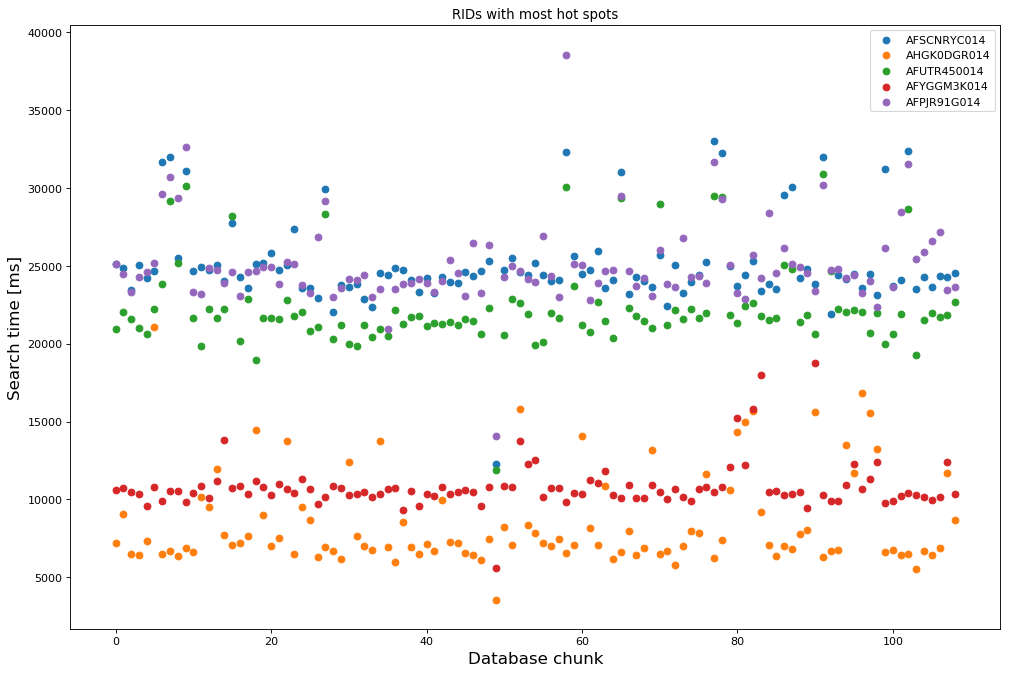

In [8]:
# RIDs with most outliers
h = (outliers > 0).sum(axis = 0).sort_values(ascending = False).head(5).index.to_list()
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for rid in h:
    plt.scatter(range(0, num_db_chunks), chunk_time[rid])
plt.xlabel('Database chunk', fontsize = 15)
plt.ylabel('Search time [ms]', fontsize = 15)
plt.title('RIDs with most hot spots')
fig = plt.legend(h)

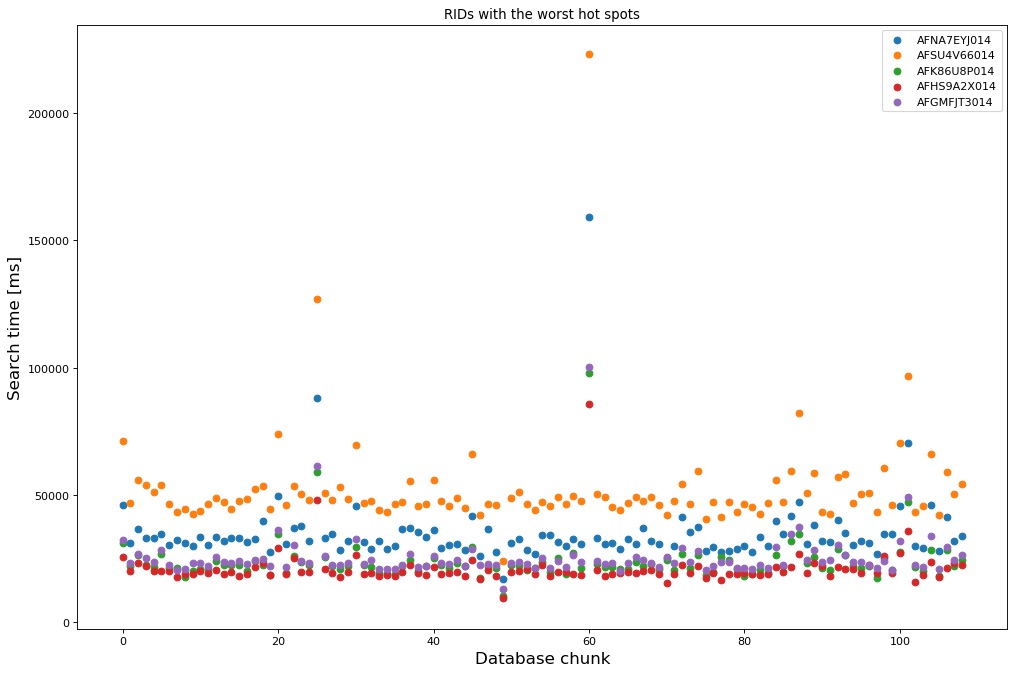

In [9]:
h = mm.sort_values(ascending = False).head(5).index.to_list()
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for rid in h:
    plt.scatter(range(0, num_db_chunks), chunk_time[rid])
plt.xlabel('Database chunk', fontsize = 15)
plt.ylabel('Search time [ms]', fontsize = 15)
plt.title('RIDs with the worst hot spots')
fig = plt.legend(h)

### Best behaving queries
Below we show five queries with the fewest hotspots and hotspots that take the shortest time to search (two figures). The run time variance bewteen queries is much larger than within.

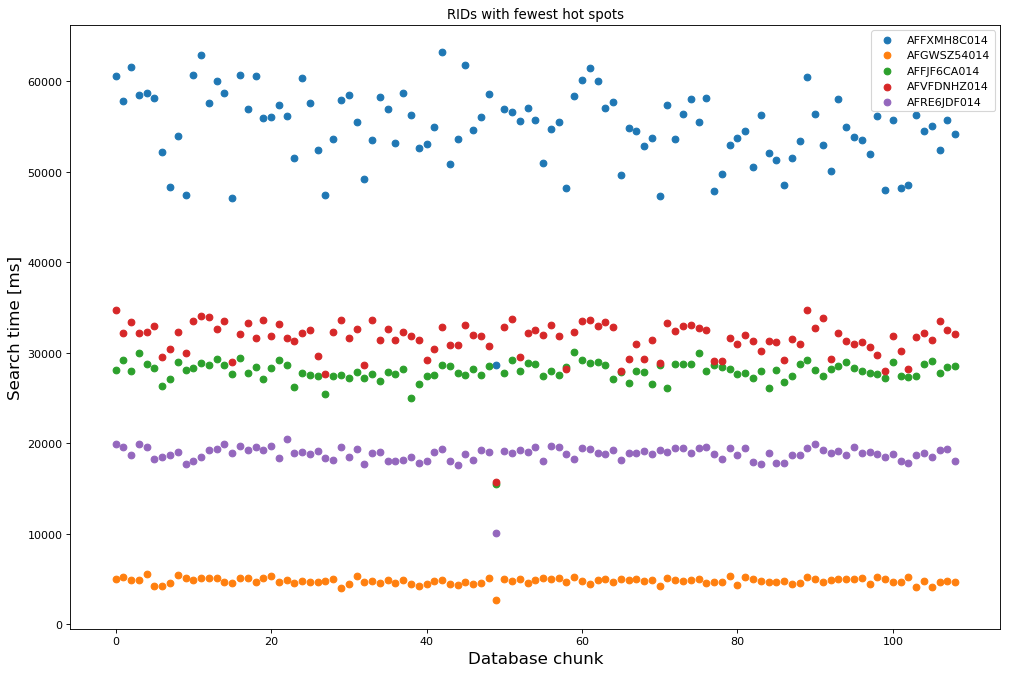

In [10]:
# RIDs with least outliers
h = (outliers > 0).sum(axis = 0).sort_values(ascending = True).head(5).index.to_list()
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for rid in h:
    plt.scatter(range(0, num_db_chunks), chunk_time[rid])
plt.xlabel('Database chunk', fontsize = 15)
plt.ylabel('Search time [ms]', fontsize = 15)
plt.title('RIDs with fewest hot spots')
fig = plt.legend(h)

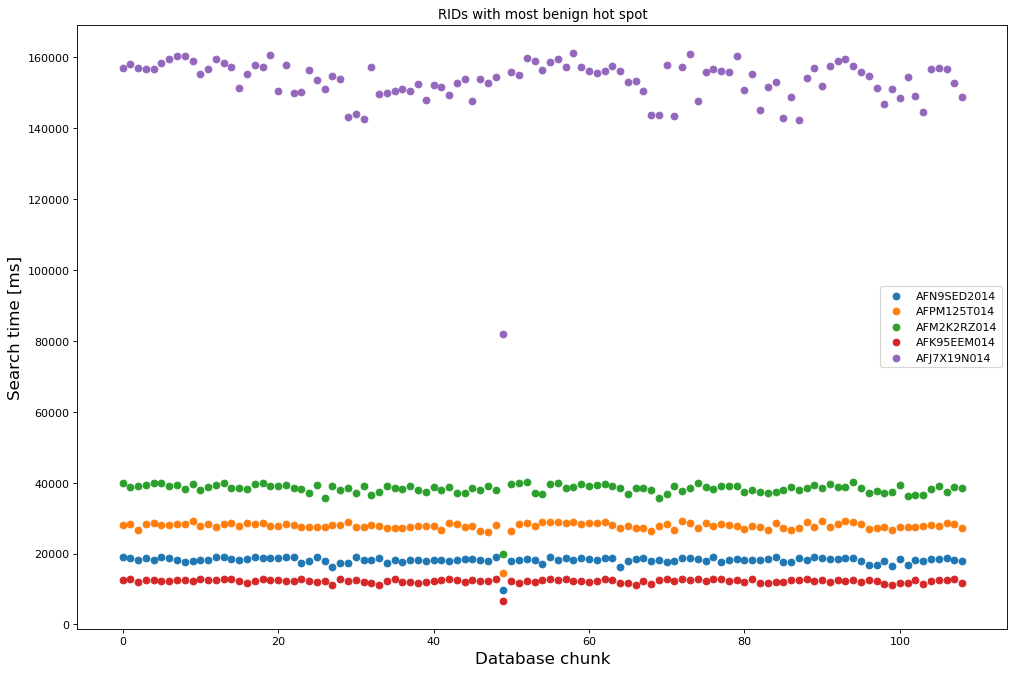

In [11]:
h = mm.sort_values(ascending = True).head(5).index.to_list()
plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
for rid in h:
    plt.scatter(range(0, num_db_chunks), chunk_time[rid])
plt.xlabel('Database chunk', fontsize = 15)
plt.ylabel('Search time [ms]', fontsize = 15)
plt.title('RIDs with most benign hot spot')
fig = plt.legend(h)